In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from types import SimpleNamespace
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.io import wavfile
from scipy.signal import correlate, decimate, find_peaks
from scipy.fftpack import fft
from scipy.signal import argrelextrema, fftconvolve
import librosa
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/test"))

# Any results you write to the current directory are saved as output.from scipy.signal import argrelextrema, fftconvolve

['F4.wav', 'F3.wav', 'M4.wav', 'F5.wav', 'F2.wav', 'M2.wav', 'M3.wav', 'M5.wav', 'M1.wav', 'F1.wav']


In [2]:
from fractions import gcd
def freq_pitch(frame, sfreq, n_fft=2048*2, threshold = 0.54, fmin = 60, fmax = 400 ):
    # Process
    ori = frame.copy()
    # Calculate autocorrelation using scipy correlate
    frame = frame.astype(np.float)
    frame -= frame.mean()
    amax = np.abs(frame).max()
    if amax > 0:
        frame /= amax
    else:
        return 0
    # Preprocessing (centre-clipping)
    data = frame.copy()
    centreclip = 0.16
    data = (abs(data) > centreclip).astype(np.int) * data
    dft_X = np.abs(np.fft.fft(data,n=n_fft))**2
    #dft_X= dft_X[1:]
    dft_log_X = np.log(dft_X)
    #dft_log_X[dft_log_X<-10] = -10
    
    
    corr = correlate(frame, frame)
    # keep the positive part
    corr = corr[len(corr)//2:]

    # Find the first minimum
    dcorr = np.diff(corr)
    rmin = np.where(dcorr > 0)[0]
    if len(rmin) > 0:
        rmin1 = rmin[0]
    else:
        return 0
    # Find the next peak
    peak = np.argmax(corr[rmin1:]) + rmin1
    rmax = corr[peak]/corr[0]
    f0 = 120

    #Baixo molt el threshold de rmax aqui perquè m'interessa que entri si no esta molt segur que es unvoiced
    if rmax > 0.2 and f0<=fmax and f0>= fmin:
        #frequ methode
        #maxims, minims = peakdet(dft_X[0:int(n_fft/2)], .6)

        pos_max = np.argmax(dft_X[0:int(n_fft/2)])


        # Convert position to Hz
        try:
            #Busco pics amd distancia major que fmin a nivell de freq, amb altitud > 0.67 el maxim absolut
            peaks =  find_peaks(dft_log_X[0:int(n_fft/4)], height=0.67*np.max(dft_log_X[0:int(n_fft/4)]),distance = (fmin*n_fft)/sfreq)[0]
            # Agafo els tres màxims més grans
            maximssss = dft_log_X[0:int(n_fft/4)].argsort()[-3:][::-1]
            #Si els dos majors pics tenen amplituds molt diferents o llindar correlation tornem unvoiced
            if maximssss[0]>1.5*maximssss[1] or  rmax < 0.4:
                '''
                plt.figure()
                plt.plot(ori)
                plt.plot(data*amax)
                plt.xlabel('time in seconds')
                plt.ylabel('amplitude')
                plt.title('Waveform')
                plt.figure()
                dft_axis = np.arange(len(dft_X[0:int(n_fft/4)]))
                dft_axis = [(elem*sfreq)/n_fft for elem in dft_axis]
                plt.plot(dft_log_X[0:int(n_fft/4)])
                plt.xlabel('f')
                plt.ylabel('amplitude')
                plt.title('DFT log')
                plt.scatter(peaks[0],dft_log_X[peaks[0]], c = 'r')
                plt.show()
                '''
                return 0
            for _i,peak in enumerate(peaks):
                #Per cada peak calculem candidat f0
                f0 =(peak*sfreq)/n_fft
                
                if f0>fmin and dft_log_X[peak]>4 and _i<len(peaks)-1:
                    # si estem en el rang i el peak era prou prominent i tenim un un altre peak a mes freq
                    if _i ==0 and f0>335:
                        # Si aquest es el primer peak que trobem i suposa f0>350
                        if peaks[_i+1]>1.75*peak and peaks[_i+1]<2.25*peak  and dft_log_X[peak]>4:
                            # si el seguent peak esta a 2f0 approx
                            f0= f0/2
                        else:
                            #és unvoiced
                        
                            return 0
                    '''figures'''


                        
                    return f0
                elif f0>=fmax:

                    return 0
            return f0
                
        except Exception as e:
            print(e)
            return 0

    else:
        return 0




In [3]:
class Counters:
    def __init__(self, gross_threshold=0.2):
        self.num_voiced = 0
        self.num_unvoiced = 0
        self.num_voiced_unvoiced = 0
        self.num_unvoiced_voiced = 0
        self.num_voiced_voiced = 0
        self.num_gross_errors = 0
        self.fine_error = 0
        self.e2 = 0
        self.gross_threshold = gross_threshold
        self.nfiles = 0

    def add(self, other):
        if other is not None:
            self.num_voiced += other.num_voiced
            self.num_unvoiced += other.num_unvoiced
            self.num_voiced_unvoiced += other.num_voiced_unvoiced
            self.num_unvoiced_voiced += other.num_unvoiced_voiced
            self.num_voiced_voiced += other.num_voiced_voiced
            self.num_gross_errors += other.num_gross_errors
            self.fine_error += other.fine_error
            self.e2 += other.e2
            self.nfiles += 1

    def __repr__(self):
        nframes = self.num_voiced + self.num_unvoiced
        if self.nfiles > 0:
            self.fine_error /= self.nfiles
        str = [
            f"Num. frames:\t{self.num_unvoiced + self.num_voiced} = {self.num_unvoiced} unvoiced + {self.num_voiced} voiced",
            f"Unvoiced frames as voiced:\t{self.num_unvoiced_voiced}/{self.num_unvoiced} ({100*self.num_unvoiced_voiced/self.num_unvoiced:.2f}%)",
            f"Voiced frames as unvoiced:\t{self.num_voiced_unvoiced}/{self.num_voiced} ({100*self.num_voiced_unvoiced/self.num_voiced:.2f}%)",
            f"Gross voiced errors (>{100*self.gross_threshold}%):\t{self.num_gross_errors}/{self.num_voiced_voiced} ({100*self.num_gross_errors/self.num_voiced_voiced:.2f}%)",
            f"MSE of fine errors:\t{100*self.fine_error:.2f}%",
            f"RMSE:\t{np.sqrt(self.e2/nframes):.2f}"
        ]
        return '\n'.join(str)

In [4]:
def compare(fref, pitch):
    vref = np.loadtxt(fref)
    vtest = np.array(pitch)

    diff_frames = len(vref) - len(vtest)
    if abs(diff_frames) > 5:
        print(f"Error: number of frames in ref ({len(vref)}) != number of frames in test ({len(vtest)})")
        return None
    elif diff_frames > 0:
        vref = np.resize(vref, vtest.shape)
    elif diff_frames < 0:
        vtest = np.resize(vtest, vref.shape)

    counters = Counters()
    counters.num_voiced = np.count_nonzero(vref)
    counters.num_unvoiced = len(vref) - counters.num_voiced
    counters.num_unvoiced_voiced = np.count_nonzero(np.logical_and(vref == 0, vtest != 0))
    counters.num_voiced_unvoiced = np.count_nonzero(np.logical_and(vref != 0, vtest == 0))

    voiced_voiced = np.logical_and(vref != 0, vtest != 0)
    counters.num_voiced_voiced = np.count_nonzero(voiced_voiced)

    f = np.absolute(vref[voiced_voiced] - vtest[voiced_voiced])/vref[voiced_voiced]
    gross_errors = f > counters.gross_threshold
    counters.num_gross_errors = np.count_nonzero(gross_errors)
    fine_errors = np.logical_not(gross_errors)
    counters.fine_error = np.sqrt(np.square(f[fine_errors]).mean())
    counters.e2 = np.square(vref - vtest).sum()

    return counters

In [5]:
from scipy.signal import butter, lfilter, freqz, medfilt, hilbert, find_peaks 
import math
from scipy.special import *
import matplotlib.pyplot as plt


def grouped(iterable, n):
    "s -> (s0,s1,s2,...sn-1), (sn,sn+1,sn+2,...s2n-1), (s2n,s2n+1,s2n+2,...s3n-1), ..."
    return zip(*[iter(iterable)]*n)


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def enforce_continuity(pitch):
    '''
    ori = pitch.copy()

    print(min(pitcheds),avg_pitch)
    
    ori[pitch>1.7*avg_pitch] = avg_pitch
    pitcheds = pitch[ori>0]
    new_avg = np.mean(pitcheds)
    pitch[pitch>1.7*avg_pitch] = new_avg
    '''
    pitcheds = pitch[pitch>0]
    avg_pitch = np.mean(pitcheds)
    new_pitch = []
    print(int(len(pitcheds)/6))
    for mini_seq in grouped(pitcheds,int(len(pitcheds/6))):
        if len(mini_seq)<10:
            return pitch
        else:
            if np.max(mini_seq)>1.3*np.mean(mini_seq):
                pitch[pitch==np.max(mini_seq)]=np.mean(mini_seq)
        
        
    return pitch

        
def wav2f0(options, gui):
    fs = open(options.submission, 'w') if options.submission is not None else None
    totalCounters = Counters()
    with open(gui) as f:
        if fs is not None:
            print('id,frequency', file=fs)
        for line in f:
            line = line.strip()
            if len(line) == 0:
                continue
            filename = os.path.join(options.datadir, line + ".wav")
            f0ref_filename = os.path.join(options.datadir, line + ".f0ref")
            print("Processing:", filename)
            sfreq, data = wavfile.read(filename)
            nsamples = len(data)

            # From miliseconds to samples
            ns_windowlength = int(round((options.windowlength * sfreq) / 1000))
            ns_frameshift = int(round((options.frameshift * sfreq) / 1000))
            ns_left_padding = int(round((options.left_padding * sfreq) / 1000))
            ns_right_padding = int(round((options.right_padding * sfreq) / 1000))
            pitch = []
             
            #Pre-processing
            cutoff_freq = 900
            n_coeficients = 10
            
            
            #data = logmmse(data, sfreq)

            # Get the filter coefficients so we can check its frequency response.
            b, a = butter_lowpass(cutoff_freq, sfreq, n_coeficients)
            centreclip = 250
            data = (abs(data) > centreclip).astype(np.int) * data
            # Filter the signal
            data = butter_lowpass_filter(data, cutoff_freq, sfreq, n_coeficients)

            
            for id, ini in enumerate(range(-ns_left_padding, nsamples - ns_windowlength + ns_right_padding + 1, ns_frameshift)):
                first_sample = max(0, ini)
                last_sample = min(nsamples, ini + ns_windowlength)
                frame = data[first_sample:last_sample]
                f0 = freq_pitch(frame, sfreq)
                if fs is not None:
                    print(line + '_' + str(id) + ',', f0, file=fs)
                pitch.append(f0)
            
            pitch = medfilt(pitch,3)
            #pitch = enforce_continuity(np.array(pitch))
            
            plt.figure()
            #plt.plot(np.loadtxt(f0ref_filename),c='b')
            plt.plot(pitch,c='r')
            plt.show()
            

            if os.path.isfile(f0ref_filename):
                counters = compare(f0ref_filename, pitch)
                totalCounters.add(counters)
            

            
            
    if totalCounters.num_voiced + totalCounters.num_unvoiced > 0:
        print("### Summary")
        print(totalCounters)
        print("-------------------------------\n")

Processing: ../input/fda_ue/rl001.wav


/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


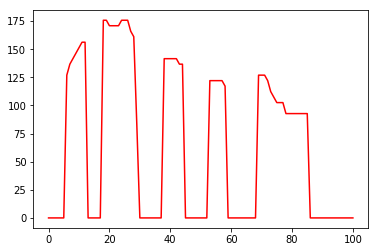

Processing: ../input/fda_ue/rl002.wav


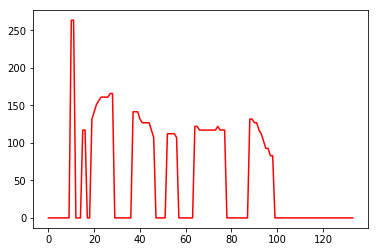

Processing: ../input/fda_ue/rl003.wav


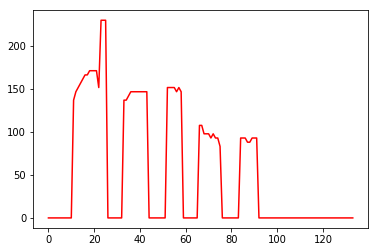

Processing: ../input/fda_ue/rl004.wav


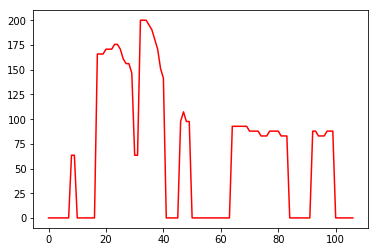

Processing: ../input/fda_ue/rl005.wav


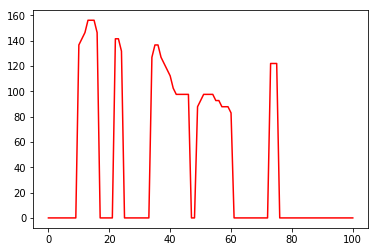

Processing: ../input/fda_ue/rl006.wav


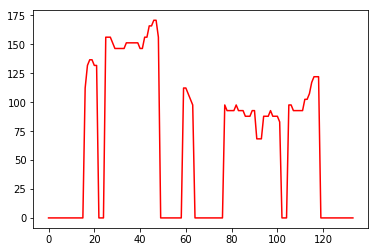

Processing: ../input/fda_ue/rl007.wav


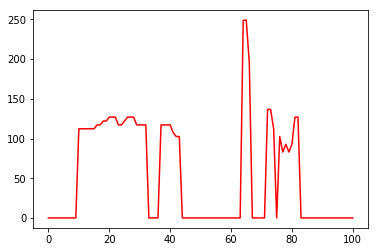

Processing: ../input/fda_ue/rl008.wav


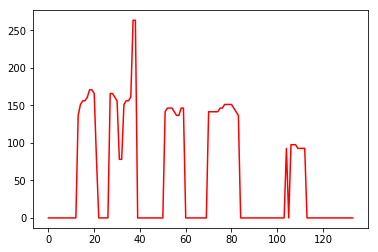

Processing: ../input/fda_ue/rl009.wav


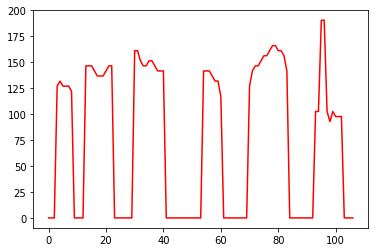

Processing: ../input/fda_ue/rl010.wav


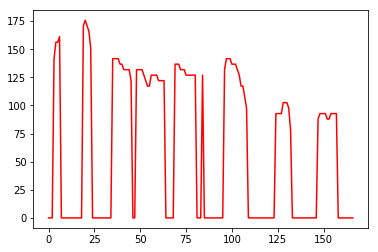

Processing: ../input/fda_ue/rl011.wav


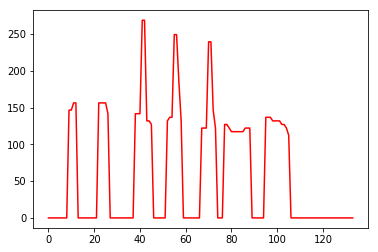

Processing: ../input/fda_ue/rl012.wav


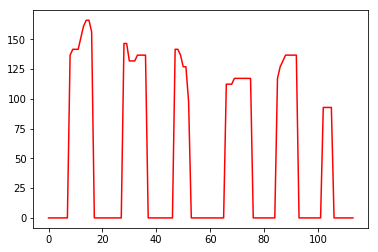

Processing: ../input/fda_ue/rl013.wav


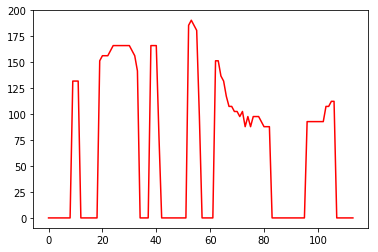

Processing: ../input/fda_ue/rl014.wav


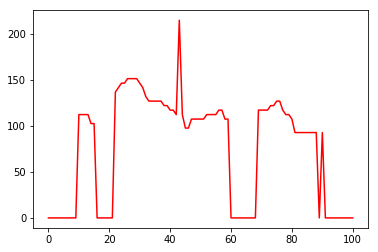

Processing: ../input/fda_ue/rl015.wav


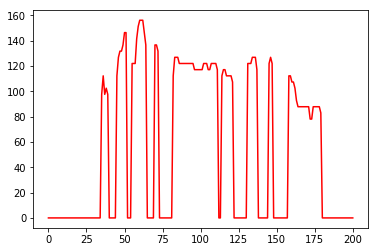

Processing: ../input/fda_ue/rl016.wav


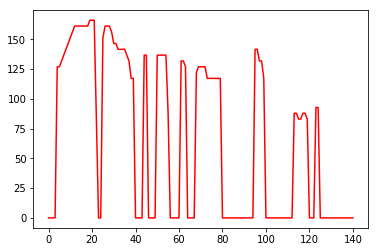

Processing: ../input/fda_ue/rl017.wav


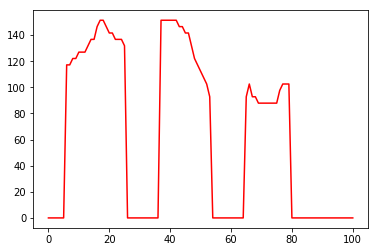

Processing: ../input/fda_ue/rl018.wav


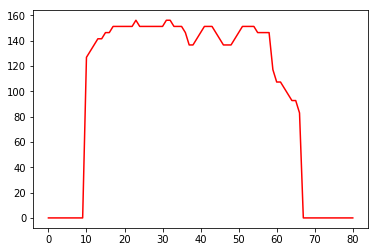

Processing: ../input/fda_ue/rl019.wav


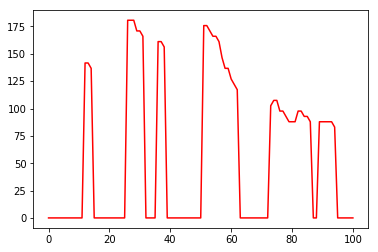

Processing: ../input/fda_ue/rl020.wav


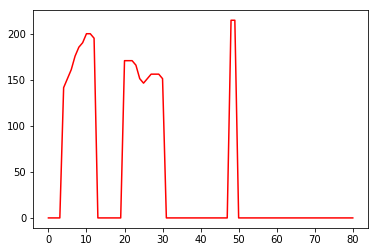

Processing: ../input/fda_ue/rl021.wav


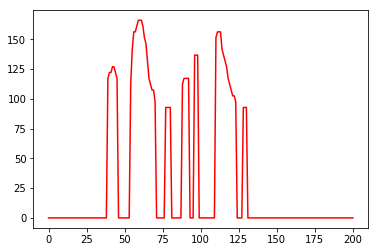

Processing: ../input/fda_ue/rl022.wav


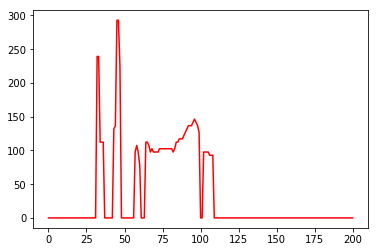

Processing: ../input/fda_ue/rl023.wav


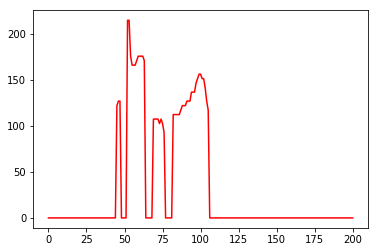

Processing: ../input/fda_ue/rl024.wav


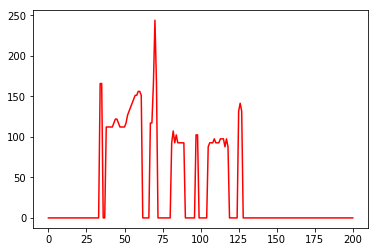

Processing: ../input/fda_ue/rl025.wav


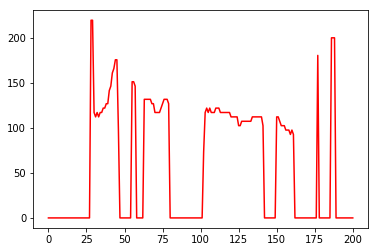

Processing: ../input/fda_ue/rl026.wav


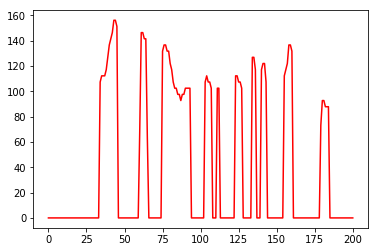

Processing: ../input/fda_ue/rl027.wav


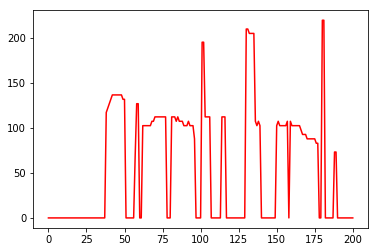

Processing: ../input/fda_ue/rl028.wav


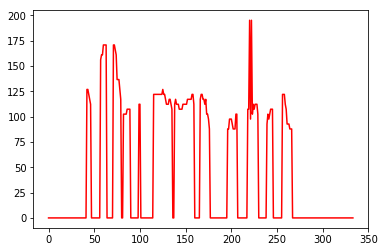

Processing: ../input/fda_ue/rl029.wav


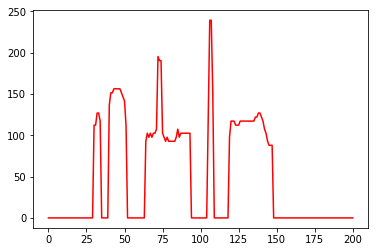

Processing: ../input/fda_ue/rl030.wav


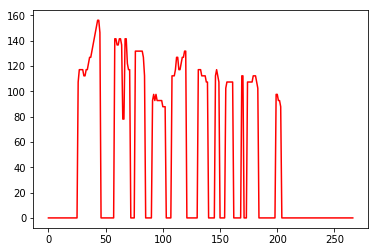

Processing: ../input/fda_ue/rl031.wav


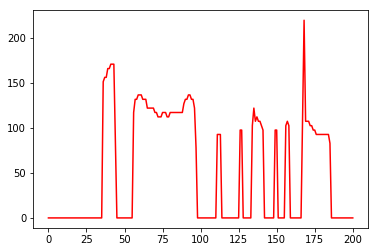

Processing: ../input/fda_ue/rl032.wav


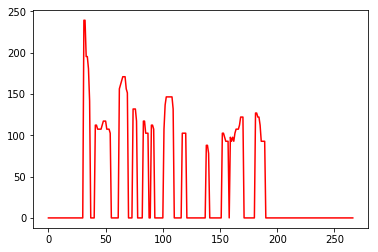

Processing: ../input/fda_ue/rl033.wav


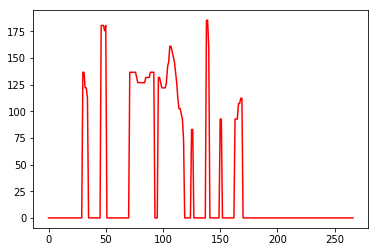

Processing: ../input/fda_ue/rl034.wav


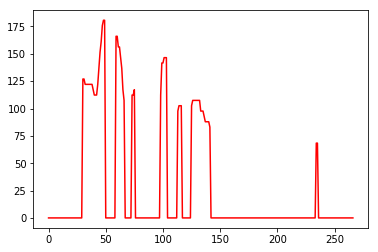

Processing: ../input/fda_ue/rl035.wav


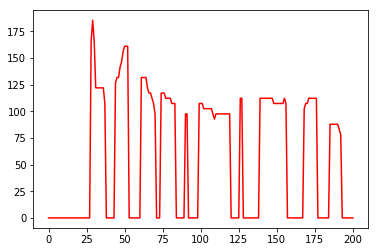

Processing: ../input/fda_ue/rl036.wav


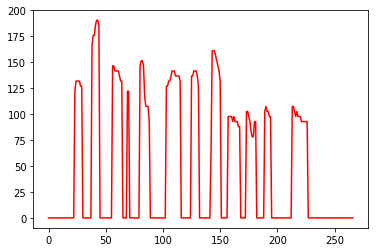

Processing: ../input/fda_ue/rl037.wav


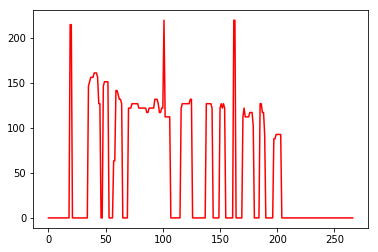

Processing: ../input/fda_ue/rl038.wav


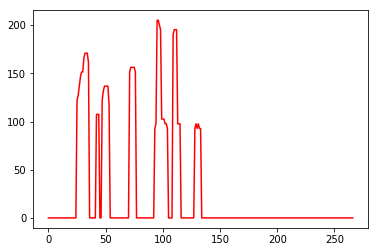

Processing: ../input/fda_ue/rl039.wav


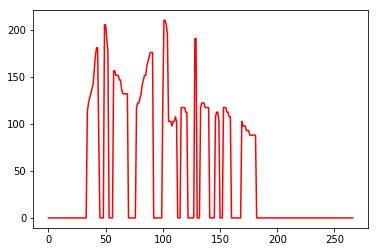

Processing: ../input/fda_ue/rl040.wav


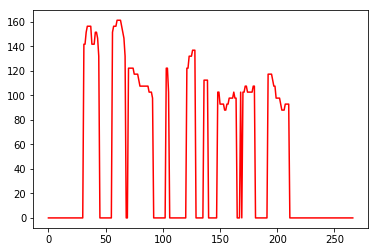

Processing: ../input/fda_ue/rl041.wav


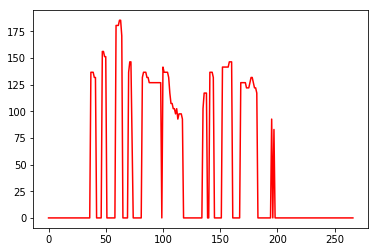

Processing: ../input/fda_ue/rl042.wav


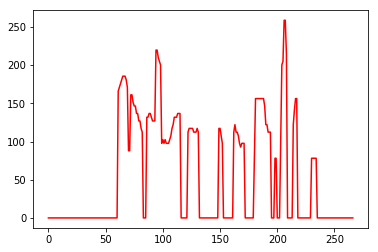

Processing: ../input/fda_ue/rl043.wav


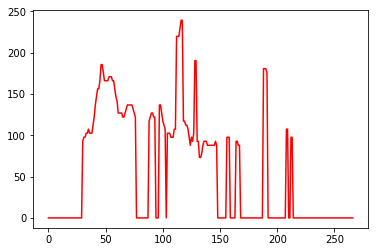

Processing: ../input/fda_ue/rl044.wav


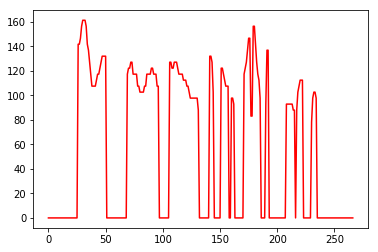

Processing: ../input/fda_ue/rl045.wav


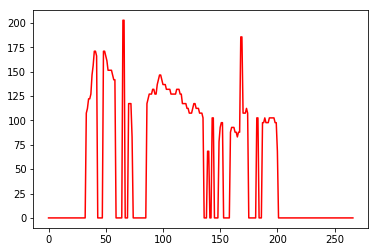

Processing: ../input/fda_ue/rl046.wav


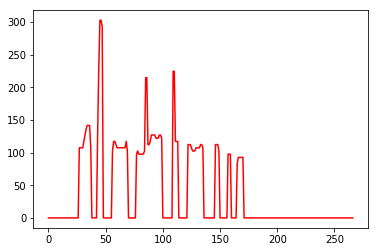

Processing: ../input/fda_ue/rl047.wav


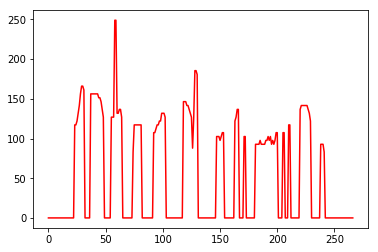

Processing: ../input/fda_ue/rl048.wav


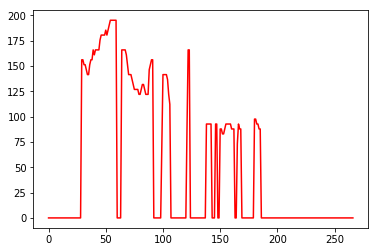

Processing: ../input/fda_ue/rl049.wav


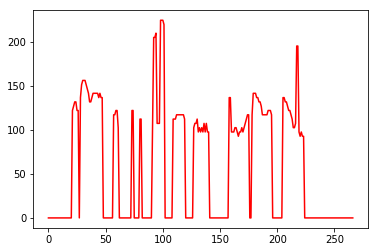

Processing: ../input/fda_ue/rl050.wav


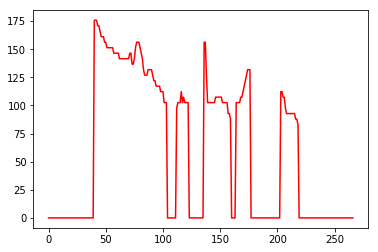

Processing: ../input/fda_ue/sb001.wav


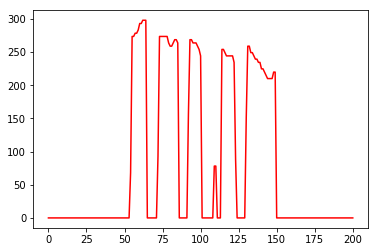

Processing: ../input/fda_ue/sb002.wav


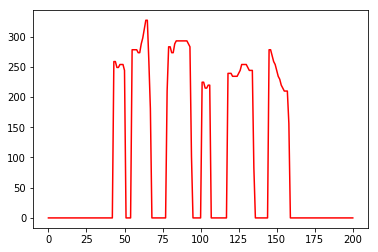

Processing: ../input/fda_ue/sb003.wav


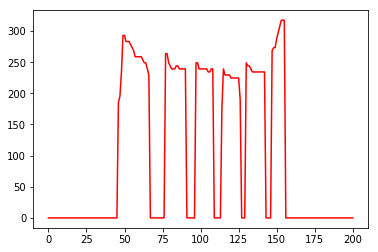

Processing: ../input/fda_ue/sb004.wav


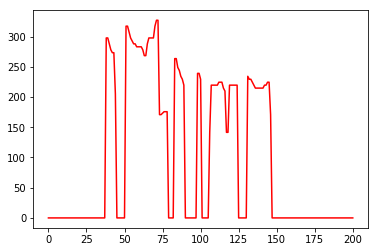

Processing: ../input/fda_ue/sb005.wav


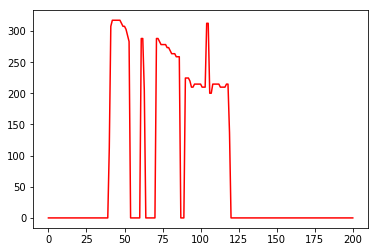

Processing: ../input/fda_ue/sb006.wav


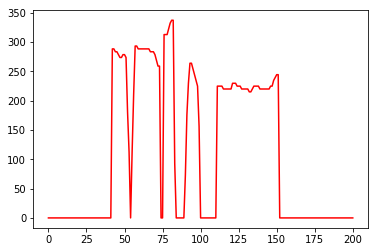

Processing: ../input/fda_ue/sb007.wav


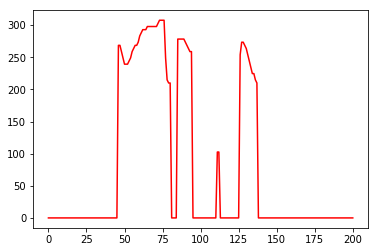

Processing: ../input/fda_ue/sb008.wav


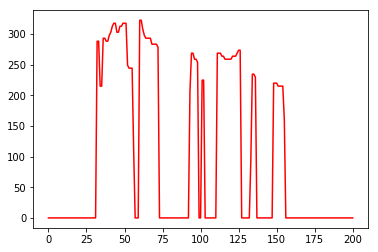

Processing: ../input/fda_ue/sb009.wav


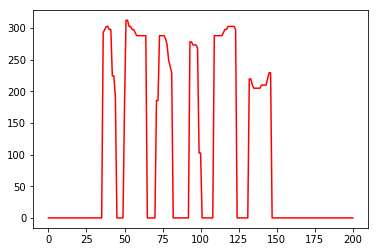

Processing: ../input/fda_ue/sb010.wav


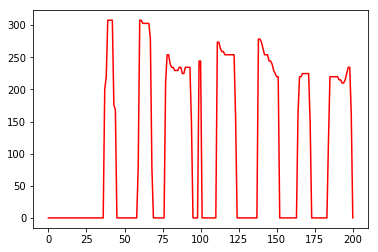

Processing: ../input/fda_ue/sb011.wav


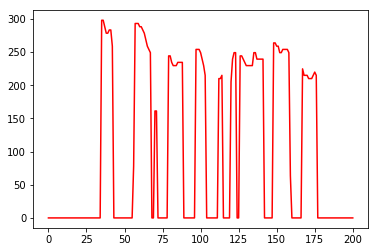

Processing: ../input/fda_ue/sb012.wav


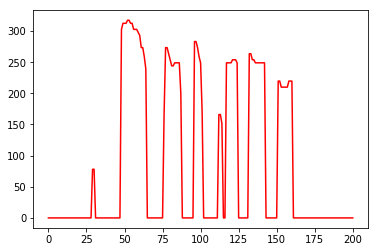

Processing: ../input/fda_ue/sb013.wav


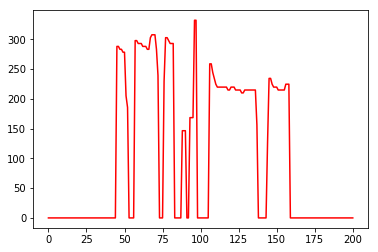

Processing: ../input/fda_ue/sb014.wav


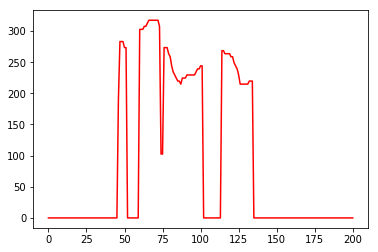

Processing: ../input/fda_ue/sb015.wav


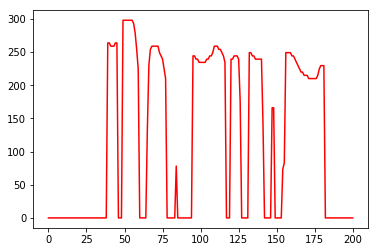

Processing: ../input/fda_ue/sb016.wav


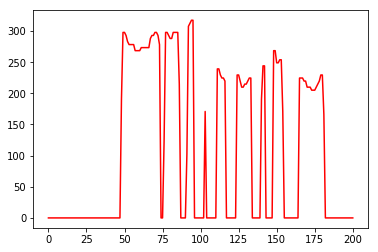

Processing: ../input/fda_ue/sb017.wav


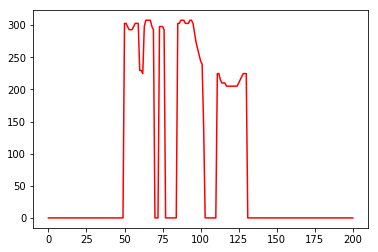

Processing: ../input/fda_ue/sb018.wav


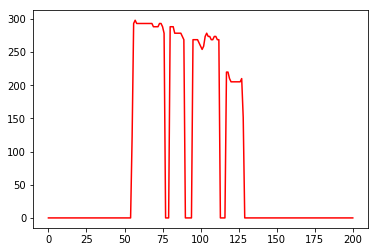

Processing: ../input/fda_ue/sb019.wav


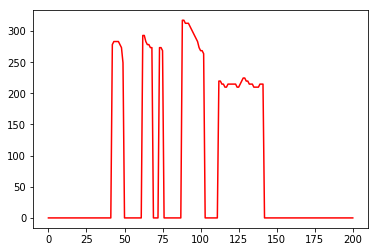

Processing: ../input/fda_ue/sb020.wav


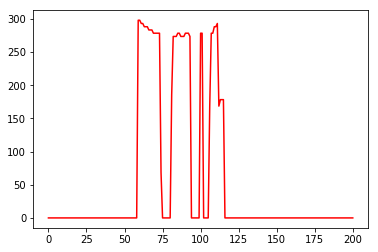

Processing: ../input/fda_ue/sb021.wav


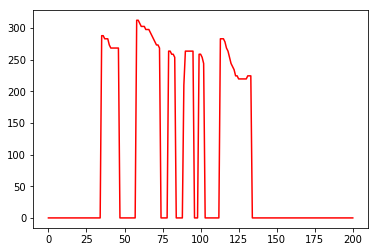

Processing: ../input/fda_ue/sb022.wav


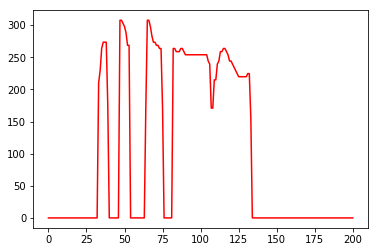

Processing: ../input/fda_ue/sb023.wav


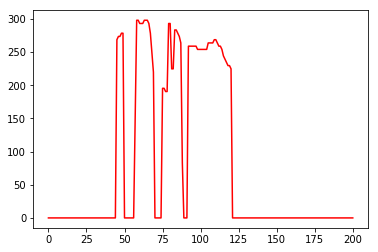

Processing: ../input/fda_ue/sb024.wav


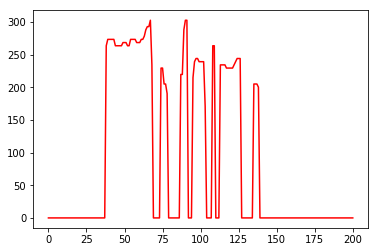

Processing: ../input/fda_ue/sb025.wav


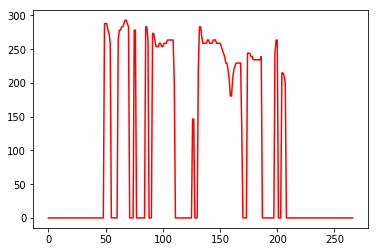

Processing: ../input/fda_ue/sb026.wav


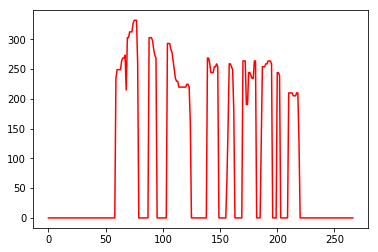

Processing: ../input/fda_ue/sb027.wav


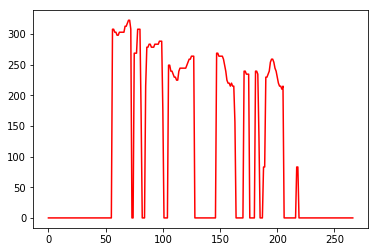

Processing: ../input/fda_ue/sb028.wav


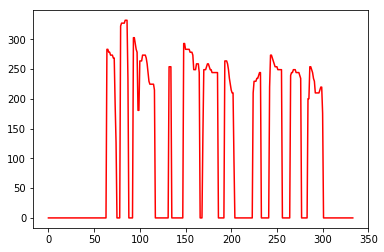

Processing: ../input/fda_ue/sb029.wav


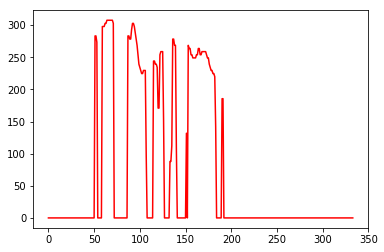

Processing: ../input/fda_ue/sb030.wav


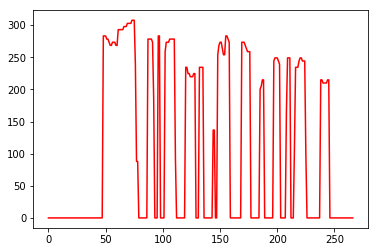

Processing: ../input/fda_ue/sb031.wav


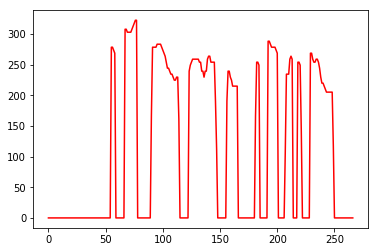

Processing: ../input/fda_ue/sb032.wav


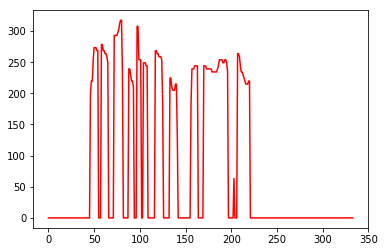

Processing: ../input/fda_ue/sb033.wav


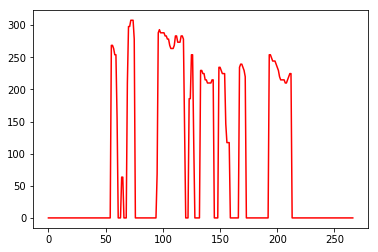

Processing: ../input/fda_ue/sb034.wav


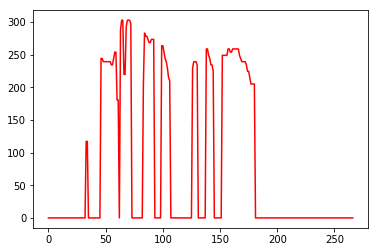

Processing: ../input/fda_ue/sb035.wav


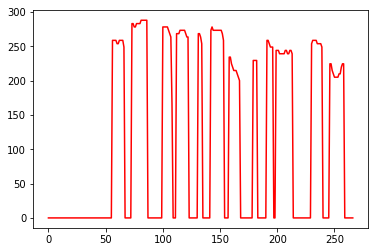

Processing: ../input/fda_ue/sb036.wav


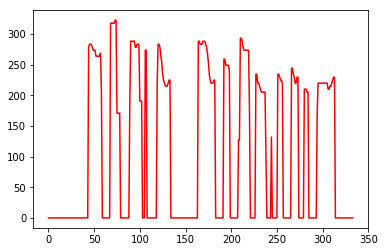

Processing: ../input/fda_ue/sb037.wav


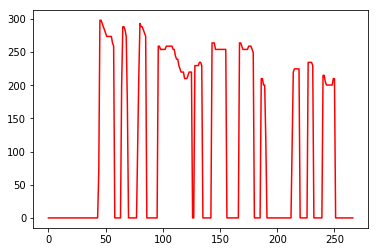

Processing: ../input/fda_ue/sb038.wav


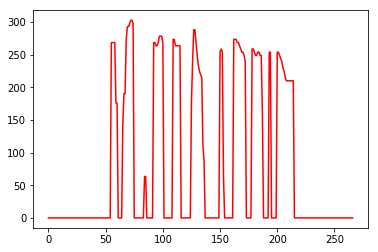

Processing: ../input/fda_ue/sb039.wav


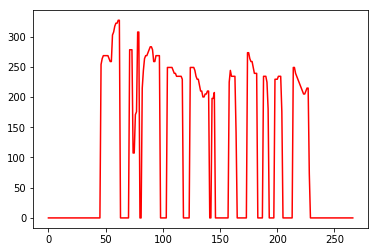

Processing: ../input/fda_ue/sb040.wav


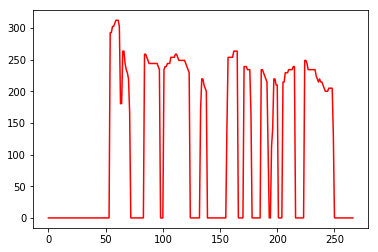

Processing: ../input/fda_ue/sb041.wav


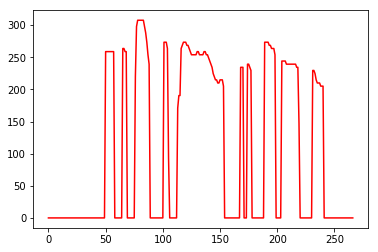

Processing: ../input/fda_ue/sb042.wav


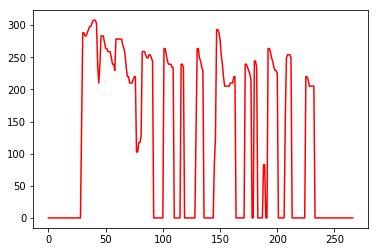

Processing: ../input/fda_ue/sb043.wav


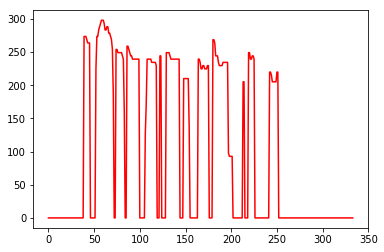

Processing: ../input/fda_ue/sb044.wav


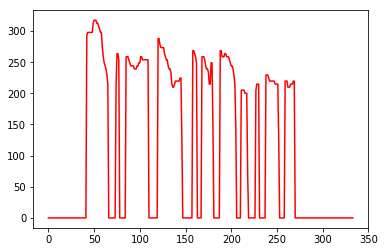

Processing: ../input/fda_ue/sb045.wav


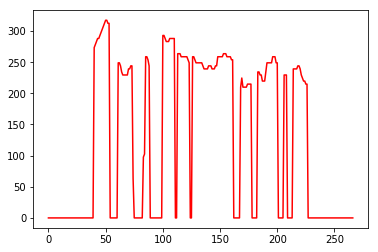

Processing: ../input/fda_ue/sb046.wav


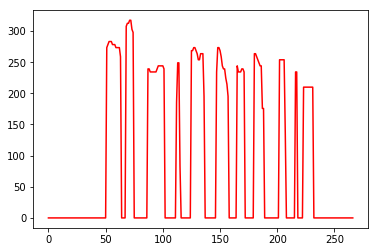

Processing: ../input/fda_ue/sb047.wav


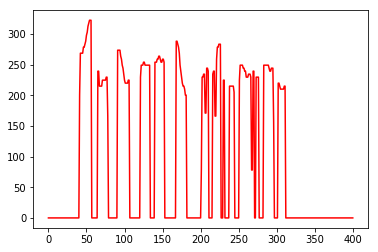

Processing: ../input/fda_ue/sb048.wav


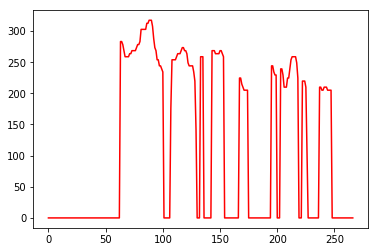

Processing: ../input/fda_ue/sb049.wav


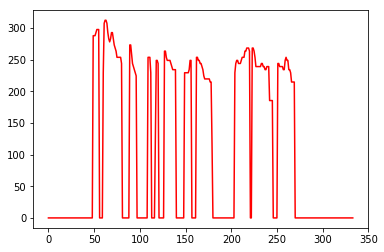

Processing: ../input/fda_ue/sb050.wav


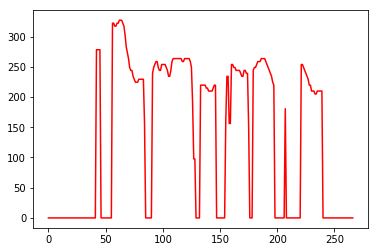

### Summary
Num. frames:	22140 = 13916 unvoiced + 8224 voiced
Unvoiced frames as voiced:	956/13916 (6.87%)
Voiced frames as unvoiced:	394/8224 (4.79%)
Gross voiced errors (>20.0%):	285/7830 (3.64%)
MSE of fine errors:	3.34%
RMSE:	46.54
-------------------------------



In [6]:
fda_ue_options = SimpleNamespace(
    windowlength=32, frameshift=15, left_padding=16, right_padding=16, datadir='../input', submission=None)
wav2f0(fda_ue_options, '../input/fda_ue.gui')


Processing: ../input/test/F1.wav


/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


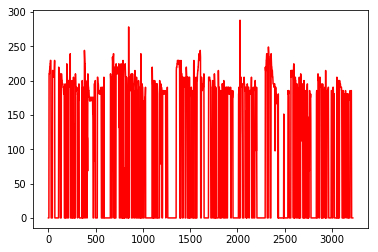

Processing: ../input/test/F2.wav


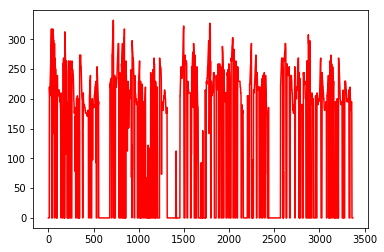

Processing: ../input/test/F3.wav


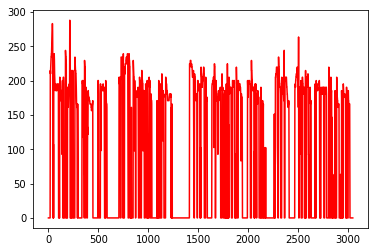

Processing: ../input/test/F4.wav


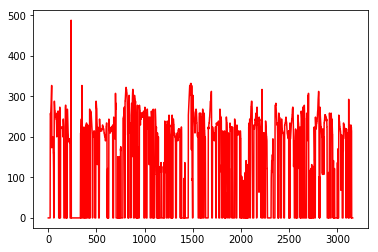

Processing: ../input/test/F5.wav


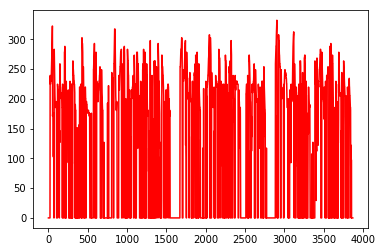

Processing: ../input/test/M1.wav


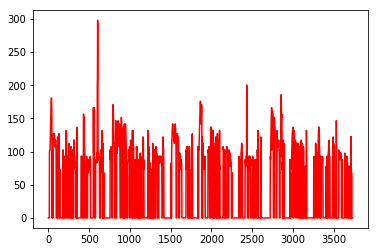

Processing: ../input/test/M2.wav


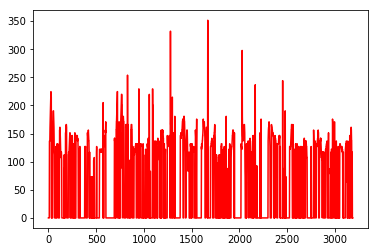

Processing: ../input/test/M3.wav


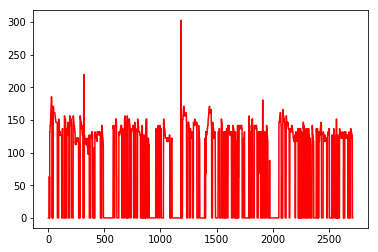

Processing: ../input/test/M4.wav


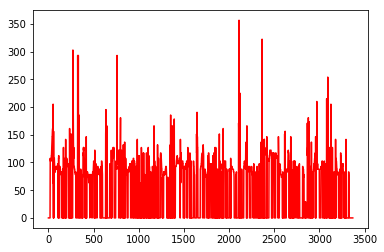

Processing: ../input/test/M5.wav


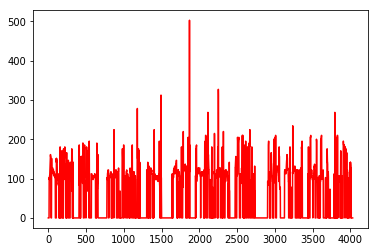

In [7]:
test_options = SimpleNamespace(
    windowlength=26.5, frameshift=10, left_padding=13.25, right_padding=7, datadir='../input/test', submission='submission.csv')
wav2f0(test_options, '../input/test.gui')